# Analisis de conversion de monedas en Republica Dominicana

# Importar modulos

In [1]:
import polars as pl
from polars import col, lit
import yfinance
import pyarrow as pa
import seaborn as sns
import matplotlib.pyplot as plt 

# Declara constantes

In [3]:
plt.style.use('tableau-colorblind10')

In [4]:
tickers = {
  "MXN=X": "Peso Mexicano",
  "BRL=X": "Real Brasileño",
  "ARS=X": "Peso Argentino",
  "COP=X": "Peso Colombiano",
  "CLP=X": "Peso Chileno",
  "PEN=X": "Sol Peruano",
  "UYU=X": "Peso Uruguayo",
  "PYG=X": "Guaraní Paraguayo",
  "BOB=X": "Boliviano Boliviano",
  # "VES=X": "Bolívar Venezolano",
  "DOP=X": "Peso Dominicano",
  "CRC=X": "Colón Costarricense",
  "CUP=X": "Peso Cubano",
  "HNL=X": "Lempira Hondureño",
  "GTQ=X": "Quetzal Guatemalteco",
  "PAB=X": "Balboa Panameño",
  "NIO=X": "Córdoba Nicaragüeño",
  "HTG=X": "Gourde Haitiano",
  "JMD=X": "Dólar Jamaicano",
  "TTD=X": "Dólar de Trinidad y Tobago",
  "BBD=X": "Dólar Barbadense",
  "BZD=X": "Dólar de Belice",
  "AWG=X": "Florín Arubeño",
  "BSD=X": "Dólar Bahameño",
  "BMD=X": "Dólar Bermudense",
  "XCD=X": "Dólar del Caribe Oriental"
}
start = '2025-01-01'
end = '2025-12-31'

In [5]:
def get_dataset(tickers) -> pl.DataFrame:
    dfs = []
    for ticker in tickers:
        df = yfinance.download(
            tickers=ticker,
            start=start,
            end=end,
            multi_level_index=False
        )
        table = pa.Table.from_pandas(df)
        df = pl.from_arrow(table)
        df = df.with_columns(lit(ticker).alias("Codigo de moneda"))
        dfs.append(df)
    
    final_df = pl.concat(items=dfs)
    return final_df.lazy()


In [6]:
df = get_dataset(tickers=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

# Genera los campos necesarios

In [7]:
q = (
    df
    .with_columns(
        col('Close')
        .first()
        .over(partition_by='Codigo de moneda',order_by='Date')
        .alias('first_price'),
        (
            col('Close') / 
            col('Close')
            .shift()
            .over(partition_by='Codigo de moneda',order_by='Date') - 1
        )
        .alias('price_change_from_prev')
    )
    .with_columns(
        ((col('Close') / col('first_price') - 1) * 100).alias('Cambio de precio')
    )
)

In [8]:
qdf = q.collect()
pivot_df = qdf.pivot(on='Codigo de moneda',values='Cambio de precio',index='Date')

[]

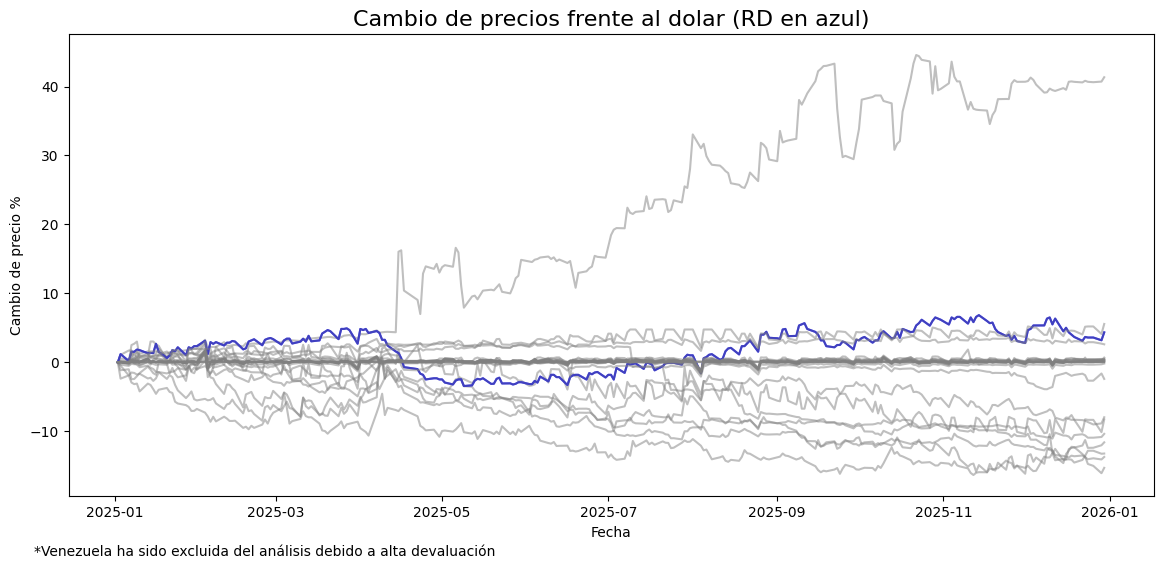

In [9]:
fig, ax = plt.subplots(figsize=(14, 6))
for ticker in tickers:
    if ticker == 'DOP=X':
        sns.lineplot(data=pivot_df,x='Date',y=ticker,legend='auto',color='blue')
    sns.lineplot(data=pivot_df,x='Date',y=ticker,legend='auto',color='grey',alpha=.5)
ax.set_title('Cambio de precios frente al dolar (RD en azul)',fontdict={"size":16})
ax.set_ylabel('Cambio de precio %')
ax.set_xlabel('Fecha')
fig.text(0.1, 0.01,'*Venezuela ha sido excluida del análisis debido a alta devaluación')
plt.plot()

In [10]:
grouped_df = (
    q
    .sort(by=['Codigo de moneda','Date'])
    .group_by('Codigo de moneda')
    .agg(
        col('Cambio de precio')
        .last()
    )
    .sort(by='Cambio de precio',descending=True)
    .with_columns(
        col('Codigo de moneda').replace_strict(tickers)
    )
    .collect()
)

In [11]:
grouped_df

Codigo de moneda,Cambio de precio
str,f64
"""Peso Argentino""",41.349854
"""Lempira Hondureño""",5.56704
"""Peso Dominicano""",4.347792
"""Dólar Jamaicano""",2.613741
"""Córdoba Nicaragüeño""",0.690673
…,…
"""Peso Uruguayo""",-10.373676
"""Real Brasileño""",-11.601592
"""Guaraní Paraguayo""",-13.224607


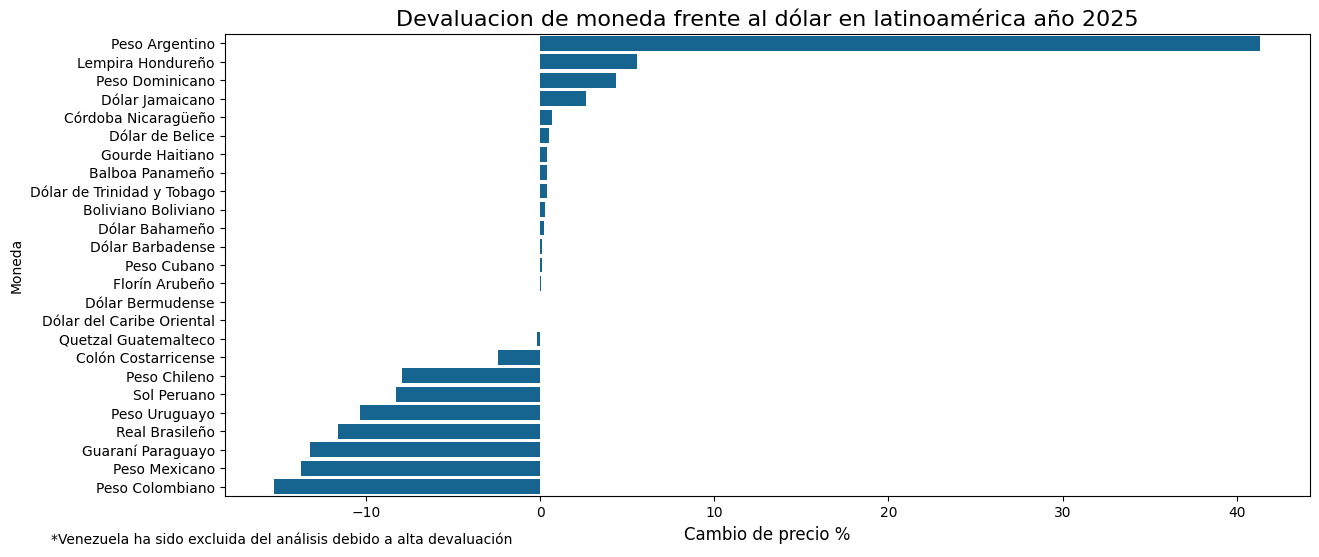

In [12]:
fig, ax = plt.subplots(figsize=(14,6))
sns.barplot(data=grouped_df,y='Codigo de moneda', x='Cambio de precio',orient='h')
ax.set_title('Devaluacion de moneda frente al dólar en latinoamérica año 2025', fontdict={'size':16})
ax.set_xlabel('Cambio de precio %',fontdict={'size':12})
ax.set_ylabel('Moneda')
fig.text(0.001, 0.03,'*Venezuela ha sido excluida del análisis debido a alta devaluación')
plt.show()

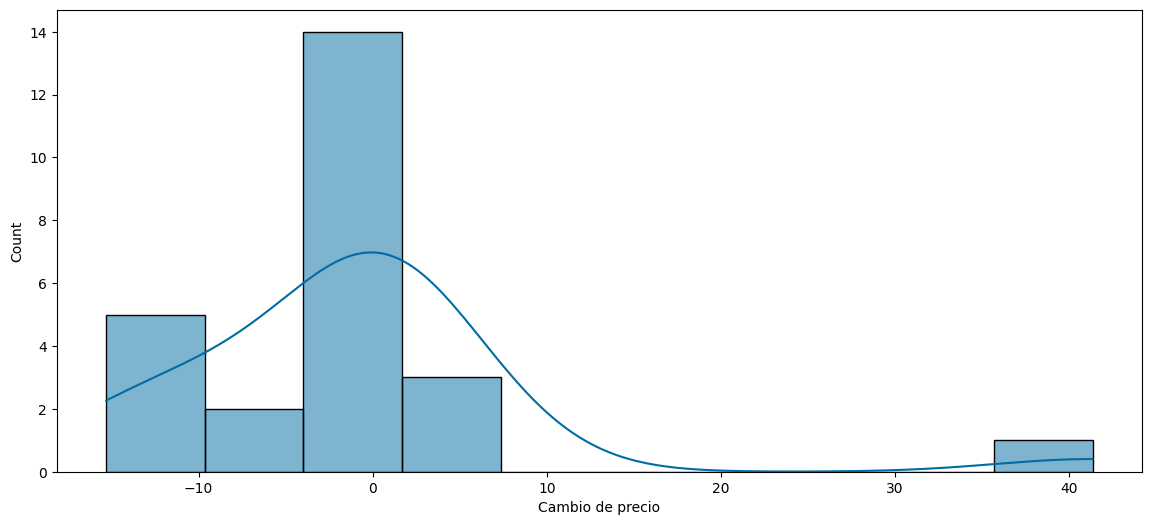

In [13]:
fig, ax = plt.subplots(figsize=(14,6))
sns.histplot(data=grouped_df,x='Cambio de precio',kde=True)
plt.show()